### Development note book for `build_heatmap()` / `build_gaussian_tf()`


In [74]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.utils       import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.visualize   import display_gt_bboxes, display_roi_proposals, plot_gaussian, plot_gaussian2
from mrcnn.visualize   import plot_pred_scatter_2, plot_pred_scatter
from mrcnn.visualize   import display_gt_bboxes, display_roi_proposals
import mrcnn.visualize as visualize
from mrcnn.prep_notebook import prep_oldshapes_dev

model, dataset_train, train_generator, config = prep_oldshapes_dev(init_with = 'last', FCN_layers = True)
model_info = [model, config, dataset_train, train_generator]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 Initialize config object - super
(56, 56)
>>> Initialize model WITHOUT MASKING LAYERS!!!!
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_development_logs\shapes20180520T1011\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
     

     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (5, 4, 32, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian_sum shape     :  (5, 4, 128, 128) Keras tensor  False
    gauss L2 norm   :  (5, 4, 128, 128)  Keras tensor  False

    normalization ------------------------------------------------------
    gauss norm   :  (5, 4, 128, 128)  Keras tensor  False
    in_tensor                (5, 4, 32, ?)
    in_tensorr_flattened is  (?, ?)
    boxes shape              (?, ?)
    Rois per image        :  32
    heatmap expanded shape : (5, 4, 1, 128, 128)
    heatmap original shape  :  (5, 4, 128, 128)
    he

In [75]:
train_batch_x, train_batch_y = next(train_generator)


>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
      Anchor  stride:   1
      Feature shapes:   [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
      Feature strides:  [4, 8, 16, 32, 64]
>>> generate_anchors()   Scale(s):  [8 8 8] Ratios:  [0.5 1.  2. ]  Heights:  [11.3137  8.      5.6569] Widths:  [ 5.6569  8.     11.3137]
>>> generate_anchors()   Scale(s):  [16 16 16] Ratios:  [0.5 1.  2. ]  Heights:  [22.6274 16.     11.3137] Widths:  [11.3137 16.     22.6274]
>>> generate_anchors()   Scale(s):  [32 32 32] Ratios:  [0.5 1.  2. ]  Heights:  [45.2548 32.     22.6274] Widths:  [22.6274 32.     45.2548]
>>> generate_anchors()   Scale(s):  [64 64 64] Ratios:  [0.5 1.  2. ]  Heights:  [90.5097 64.     45.2548] Widths:  [45.2548 64.     90.5097]
>>> generate_anchors()   Scale(s):  [128 128 128] Ratios:  [0.5 1.  2. ]  Heights:  [181.0193 128.      90.5097] Widths:  [ 90.5097 128.     181.0193]
    Size of anchor array is : (40

Image id:  132
Image meta [132 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 2 3]


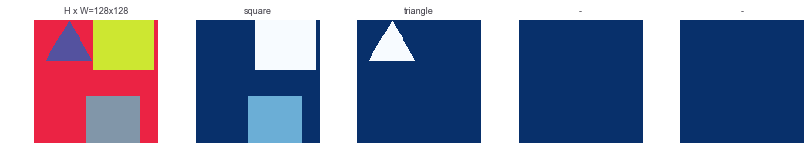

Image id:  38
Image meta [ 38 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 3]


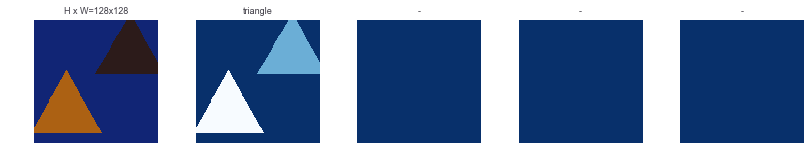

Image id:  85
Image meta [ 85 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 3]


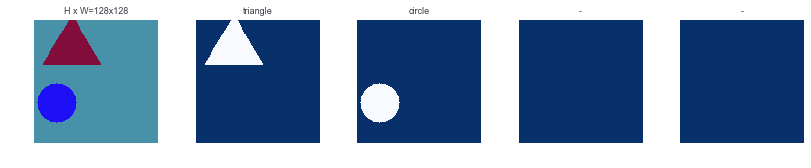

Image id:  57
Image meta [ 57 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1]


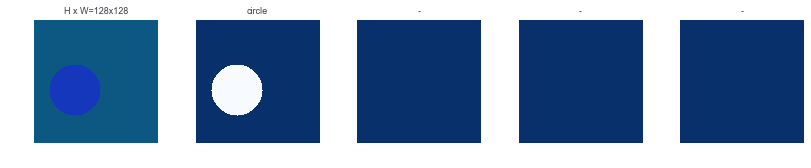

Image id:  87
Image meta [ 87 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 2 2]


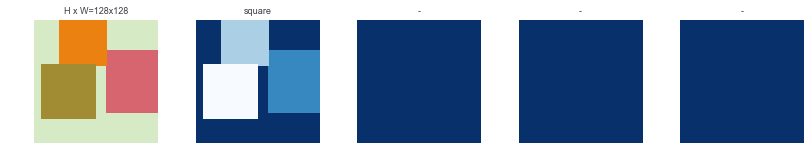

In [76]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [77]:
model.layer_info()
# model.keras_model.outputs[0].name



 Inputs:
 -------
 layer:  0    output : input_image:0                              Type: float32           Shape: (?, 128, 128, 3)
 layer:  1    output : input_image_meta:0                         Type: float32           Shape: (?, ?)
 layer:  2    output : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 layer:  3    output : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 layer:  4    output : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 layer:  5    output : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)
 layer:  6    output : input_gt_masks:0                           Type: bool              Shape: (?, 56, 56, ?)


 Outputs:
 --------
 layer:  0    output : rpn_class_logits/concat:0                  Type: float32           Shape: (?, ?, 2)
 layer:  1    output : rpn_class/concat:0                         Type: float32           Shape:

In [7]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(model.keras_model, train_batch_x, [4,5,7,15,16,17,18,19,20,21,22,23,24,25,26,27,28], 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (5, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (5, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (5, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (5, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (5, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (5, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (5, 56, 56, 100)

/* Outputs */
Output idx:  0    Layer:  4: (proposal_targets/output_rois:0          ) 	  Output shape: (5, 32, 4)
Output idx:  1    Layer:  5: (proposal_targets/target_class_ids:0     ) 	  Output shape: (5, 32)
Output idx:  2    Layer:  7: (proposal_targets/roi_gt_boxes:0         ) 	  Output shape: (5, 32, 4)
Output idx:  3    Layer: 15: (cntxt_layer/pred_heatmap_norm:0         ) 	  Output shape: (5, 128,

In [78]:
print(len(model_output))

output_rois               = model_output[0]          # layer:  4   shape: (5, 32, 4)
target_class_ids          = model_output[1]          # layer:  5   shape: (5, 32)
roi_gt_boxes              = model_output[2]          # layer:  7   shape: (5, 32, 4)
pred_heatmap_norm         = model_output[3]          # layer: 15   shape: (5, 128, 128, 4)
gt_heatmap_norm           = model_output[4]          # layer: 16   shape: (5, 128, 128, 4)
pred_heatmap_scores       = model_output[5]          # layer: 17   shape: (5, 4, 32, 11)
gt_heatmap_scores         = model_output[6]          # layer: 18   shape: (5, 4, 32, 11)
pred_tensor               = model_output[7]          # layer: 19   shape: (5, 4, 32, 6)
gt_tensor                 = model_output[8]          # layer: 20   shape: (5, 4, 32, 6)
pred_heatmap              = model_output[9]          # layer: 21   shape: (5, 128, 128, 4)
gt_heatmap                = model_output[10]          # layer: 22   shape: (5, 128, 128, 4)
pred_heatmap_L2norm       = model_output[11]          # layer: 23   shape: (5, 128, 128, 4)
gt_heatmap_L2norm         = model_output[12]          # layer: 24   shape: (5, 128, 128, 4)
Select                    = model_output[13]          # layer: 25   shape: (5, 128, 128, 4)
fcn_scores                = model_output[14]          # layer: 26   shape: (5, 4, 32, 16)
fcn_heatmap               = model_output[15]          # layer: 27   shape: (5, 128, 128, 4)
fcn_heatmap_L2norm        = model_output[16]          # layer: 28   shape: (5, 128, 128, 4)

for i in model_output:
    print( i.shape)

17
(5, 32, 4)
(5, 32)
(5, 32, 4)
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 4, 32, 11)
(5, 4, 32, 11)
(5, 4, 32, 6)
(5, 4, 32, 6)
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 4, 32, 16)
(5, 128, 128, 4)
(5, 128, 128, 4)


In [10]:
input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes    = train_batch_x[5]
input_gt_masks     = train_batch_x[6]
print(' Input image shape is :', input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)
print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)


 Input image shape is : (5, 128, 128, 3)
 input_rpn_match     (5, 4092, 1)
 input_rpn_bbox      (5, 256, 4)
 input_gt_class_ids  (5, 100)
 input_gt_bboxes     (5, 100, 4)
 input_normlzd_gt_bboxes     (5, 100, 4)


####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=120, suppress=True)
img = 0

# print(KB.int_shape(output_rois))
# print(output_rois[img,:15]*[128, 128,128,128])
# print(input_gt_class_ids[0])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype)
# print(pred_heatmap_scores[img,:,:10])

# print(' FCN Scores')
# print(fcn_scores.dtype)
# print(fcn_scores[img,:,:10, 4:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

## `build_heatmap()`

#### Prepare values to pass to build_heatmap


####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img])


####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])

####  `build_mask_routine()`

In [79]:
def build_mask_routine(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    heatmap_tensor, input_row = input_list
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_row[0], input_row[2])
        x_extent     = tf.range(input_row[1], input_row[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        mask_sum    =  tf.reduce_sum(mask)
        mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]))
        gaussian_sum = tf.reduce_sum(mask_applied)
        ratio        = gaussian_sum / bbox_area 
        ratio        = tf.where(tf.is_nan(ratio),  0.0, ratio)  
    return tf.stack([gaussian_sum, bbox_area, ratio], axis = -1)
    
    

####  `build_heatmap()`

In [238]:
# def build_heatmap(in_tensor, config, names = None):
in_tensor   = tf.identity(pred_tensor)
sess = KB.get_session()
config = model.config
names = ['test']



with sess.as_default():    
# def build_heatmap(in_tensor, config, names = None):
 
 
    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    print('\n ')
    print('  > NEW build_heatmap() for ', names )
    print('    orignal in_tensor shape : ', in_tensor.shape)       
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    rois_per_image  = (in_tensor.shape)[2] 
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image )

    #-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    #-----------------------------------------------------------------------------
    # pt2_ind shape is [?, 3]. 
    #   pt2_ind[0] corresponds to image_index 
    #   pt2_ind[1] corresponds to class_index 
    #   pt2_ind[2] corresponds to roi row_index 
    # pt2_dense shape is [?, 6]  (number of non_zero pt2_sums)
    #    pt2_dense[0] is image index
    #    pt2_dense[1:4]  roi cooridnaytes 
    #    pt2_dense[5]    is class id 
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
    print('    pt2_sum shape ',pt2_sum.shape)
    # print(pt2_sum[0].eval())
    pt2_ind = tf.where(pt2_sum > 0)

    ## replaced the two operations below with the one above - 15-05-2018
    # pt2_mask = tf.greater(pt2_sum , 0)
    # pt2_ind  = tf.where(pt2_mask)
    # print(' pt2_mask shape ', pt2_mask.get_shape())
    # print(pt2_mask.eval())
    # print('    pt2_ind shape ', pt2_ind.get_shape())
    # print(pt2_ind.eval())

    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)
    print('    dense shape ',pt2_dense.get_shape())

    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(img_w, dtype=tf.int32)
    Y = tf.range(img_h, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([tf.shape(pt2_dense)[0] , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', bef_pos.get_shape())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', pos_grid.get_shape())    

    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_dense[:,3] - pt2_dense[:,1]      # x2 - x1
    height = pt2_dense[:,2] - pt2_dense[:,0]
    cx     = pt2_dense[:,1] + ( width  / 2.0)
    cy     = pt2_dense[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())

    #--------------------------------------------------------------------------------
    ## IMPORTANT: kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    ## which cause singular sigma cov matrices
    #--------------------------------------------------------------------------------
    prob_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


    # scatter out the probability distributions based on class --------------------------
    print('\n    Scatter out the probability distributions based on class --------------') 
    gauss_scatt   = tf.scatter_nd(pt2_ind, prob_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])
    print('    pt2_ind shape   : ', pt2_ind.shape)  
    print('    prob_grid shape : ', prob_grid.shape)  
    print('    gauss_scatt     : ', gauss_scatt.shape)   # batch_sz , num_classes, num_rois, image_h, image_w
    
    # heatmap: sum gauss_scattered based on class ---------------------------------------
    print('\n    Reduce sum based on class ---------------------------------------------')         
    gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap2')
    gauss_sum = tf.where(gauss_sum > 1e-12, gauss_sum, tf.zeros_like(gauss_sum))
    
    print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      
    
    ##---------------------------------------------------------------------------------------------
    ## heatmap L2 normalization
    ## Normalization using the  `gauss_sum` (batchsize , num_classes, height, width) 
    ## 17-05-2018 (New method, replace dthe previous method that usedthe transposed gauss sum
    ## 17-05-2018 Replaced with normalization across the CLASS axis 
    ##---------------------------------------------------------------------------------------------

    # print('\n    L2 normalization ------------------------------------------------------')   
    gauss_L2norm   = KB.l2_normalize(gauss_sum, axis = +1)   # normalize along the CLASS axis 
    print('    gauss L2 norm   : ', gauss_L2norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_L2norm) )

    print('\n    normalization ------------------------------------------------------')   
    gauss_norm    = gauss_sum / tf.reduce_max(gauss_sum, axis=[-2,-1], keepdims = True)
    gauss_norm    = tf.where(tf.is_nan(gauss_norm),  tf.zeros_like(gauss_norm), gauss_norm)
    print('    gauss norm   : ', gauss_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )
    
    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ## NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
    ##       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_shape = tf.shape(in_tensor)
    in_tensor_flattened  = tf.reshape(in_tensor, [-1, in_shape[-1]])
    bboxes = tf.to_int32(tf.round(in_tensor_flattened[...,0:4]))
    print('    in_tensor               ', in_tensor.shape)
    print('    in_tensorr_flattened is ', in_tensor_flattened.shape)
    print('    boxes shape             ', bboxes.shape)
    print('    Rois per image        : ', rois_per_image)


    #--------------------------------------------------------------------------------------------------------------------------
    # duplicate GAUSS_NORM <num_roi> times to pass along with bboxes to map_fn function
    #   Here we have a choice to calculate scores using the GAUSS_SUM (unnormalized) or GAUSS_NORM (normalized)
    #   after looking at the scores and ratios for each option, I decided to go with the normalized 
    #   as the numbers are larger
    #
    # Examples>
    #   Using GAUSS_SUM
    # [   3.660313    3.513489   54.475536   52.747402    1.          0.999997    4.998889 2450.          0.00204     0.444867]
    # [   7.135149    1.310972   50.020126   44.779854    1.          0.999991    4.981591 1892.          0.002633    0.574077]
    # [  13.401865    0.         62.258957   46.636948    1.          0.999971    4.957398 2303.          0.002153    0.469335]
    # [   0.          0.         66.42349    56.123024    1.          0.999908    4.999996 3696.          0.001353    0.294958]
    # [   0.          0.         40.78952    60.404335    1.          0.999833    4.586552 2460.          0.001864    0.406513]    
    #
    #   Using GAUSS_NORM:
    # [   3.660313    3.513489   54.475536   52.747402    1.          0.999997 1832.9218   2450.          0.748131    0.479411]
    # [   7.135149    1.310972   50.020126   44.779854    1.          0.999991 1659.3965   1892.          0.877059    0.56203 ]
    # [  13.401865    0.         62.258957   46.636948    1.          0.999971 1540.4974   2303.          0.668909    0.428645]
    # [   0.          0.         66.42349    56.123024    1.          0.999908 1925.3267   3696.          0.520922    0.333813]
    # [   0.          0.         40.78952    60.404335    1.          0.999833 1531.321    2460.          0.622488    0.398898]
    # 
    #  to change the source, change the following line gauss_norm <--> gauss_sum
    #---------------------------------------------------------------------------------------------------------------------------
    temp = tf.expand_dims(gauss_norm, axis =2)
    print('    heatmap expanded shape :',  temp.get_shape())
    temp = tf.tile(temp, [1,1, rois_per_image ,1,1])
    temp_shape   = KB.int_shape(temp)
    temp_reshape = KB.reshape(temp, (-1, temp_shape[-2], temp_shape[-1]))
    print('    heatmap original shape  : ', gauss_norm.shape)
    print('    heatmap replicated      : ', temp_shape)
    print('    heatmap flattened       : ', temp_reshape.shape)

    scores = tf.map_fn(build_mask_routine, [temp_reshape, bboxes], dtype=tf.float32)


    # consider the two new columns for reshaping the gaussian_bbox_scores
    new_shape   = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
    bbox_scores = tf.concat([in_tensor_flattened, scores], axis = -1)
    bbox_scores = tf.reshape(bbox_scores, new_shape)
    # print('    new shape is            : ', new_shape.eval())
    print('    in_tensor_flattened     : ', in_tensor_flattened.shape)
    print('    Scores shape            : ', scores.shape)   # [(num_batches x num_class x num_rois ), 3]
    print('    boxes_scores (rehspaed) : ', bbox_scores.shape)    

    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
    scr_L2norm   = tf.nn.l2_normalize(bbox_scores[...,-1], axis = -1)   # shape (num_imgs, num_class, num_rois)
    scr_L2norm   = tf.expand_dims(scr_L2norm, axis = -1)
   
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    scr_norm     = bbox_scores[...,-1]/ tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm)  
    scr_norm     = tf.expand_dims(scr_norm, axis = -1)                             # shape (num_imgs, num_class, 32, 1)
#     print('scr_norm shape ',tf.shape(scr_norm).eval())    
    bbox_scores  = tf.concat([bbox_scores, scr_norm ,scr_L2norm], axis = -1)
    
    gauss_heatmap      = KB.identity(tf.transpose(gauss_sum,[0,2,3,1]), name = names[0])
    gauss_heatmap_norm = KB.identity(tf.transpose(gauss_norm,[0,2,3,1]), name = names[0]+'_norm')
    gauss_heatmap_L2norm = KB.identity(tf.transpose(gauss_L2norm,[0,2,3,1]), name = names[0]+'_L2norm')
    gauss_scores = KB.identity(bbox_scores, name = names[0]+'_scores') 
    
    print('    gauss_heatmap final shape : ', gauss_heatmap.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap) )  
    print('    gauss_scores  final shape : ', gauss_scores.shape ,' Keras tensor ', KB.is_keras_tensor(gauss_scores) )  
    print('    complete')

#     return  gauss_heatmap, gauss_heatmap_norm, gauss_heatmap_L2norm, gauss_scores    # [gauss_sum, gauss_scatt, means, covar]    
    



 
  > NEW build_heatmap() for  ['test']
    orignal in_tensor shape :  (5, 4, 32, 6)
    num of bboxes per class is :  32
    pt2_sum shape  (5, 4, 32)
    dense shape  (?, 6)
    X/Y shapes : (128, 128) (128, 128)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (128, 128) =  (?, 128, 128)
    ones_exp * Y (?, 1, 1) * (128, 128) =  (?, 128, 128)
    before transpse  (?, 128, 128, 2)
    after transpose  (128, 128, ?, 2)
     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (5, 4, 32, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian_sum shape     :  (5, 4, 128, 128) Keras tensor  False
    gauss L2 

In [279]:
np.set_printoptions(precision=4, threshold=10000, linewidth=120, suppress=True)
with sess.as_default():
    gauss_scatt         = gauss_scatt.eval()
    pred_heatmap        = gauss_heatmap.eval()
    pred_heatmap_norm   = gauss_heatmap_norm.eval()
    pred_heatmap_L2norm   = gauss_heatmap_L2norm.eval()
    pred_heatmap_scores = gauss_scores.eval()
    prob_grid           = prob_grid.eval()

AttributeError: 'numpy.ndarray' object has no attribute 'eval'

In [280]:
img = 0
# print(res)
print(gauss_sum.shape)
print(gauss_scatt.shape)
print(pred_heatmap.shape)
print(pred_heatmap_norm.shape)
print(pred_heatmap_L2norm.shape)


(5, 4, 128, 128)
(5, 4, 32, 128, 128)
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 128, 128, 4)


### Plot heatmap of  one `gauss_scatter` distribution generated in `build_heatmap`

Image id:  87    Classes (1: circle, 2: square, 3: triangle ): 
[  25.232     0.      128.       37.6419    0.        0.4656  278.6541 3914.        0.0712    0.4778    0.2842]


<IPython.core.display.Javascript object>


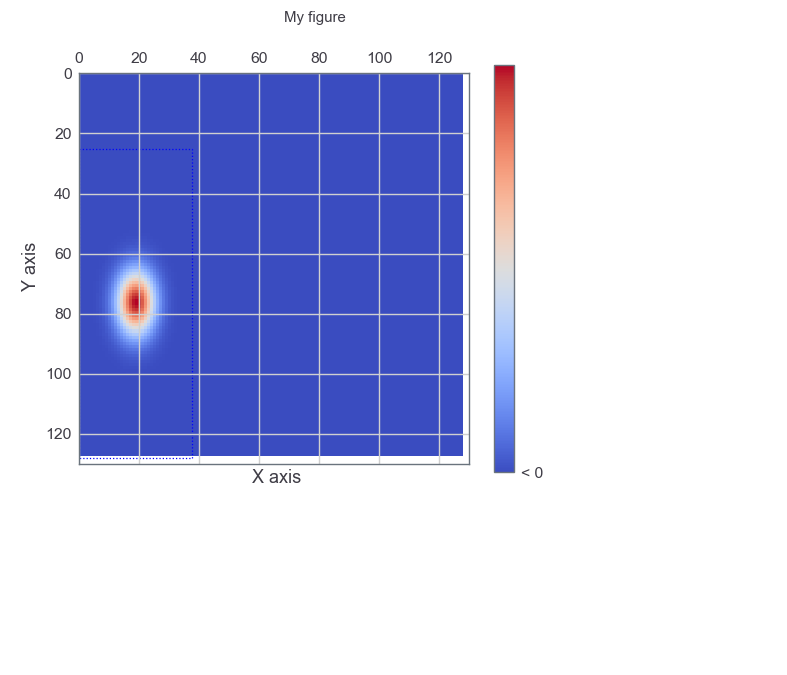

In [302]:
from mrcnn.visualize import plot_one_bbox_heatmap
import matplotlib as plt

%matplotlib notebook
print('Image id: ',image_id, '   Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
cls = 0 
box = 0
print(pred_heatmap_scores[img,cls,box])
plot_one_bbox_heatmap(gauss_scatt[img,cls,box], pred_tensor[img,cls,box], width = 7, height=7)

###  Display `pred_scatter` heatmaps for all bounding boxes of an image

Image id:  87     Classes (1: circle, 2: square, 3: triangle ): 
[ 75.1388   0.     128.       0.       0.       0.5825   0.       0.       0.       0.       0.    ]
shape of z (4, 32, 128, 128) shape of boxes (4, 32, 6)
Number of classes is : 4 num_boxes: 12 rows : 3 columns:  4


<IPython.core.display.Javascript object>


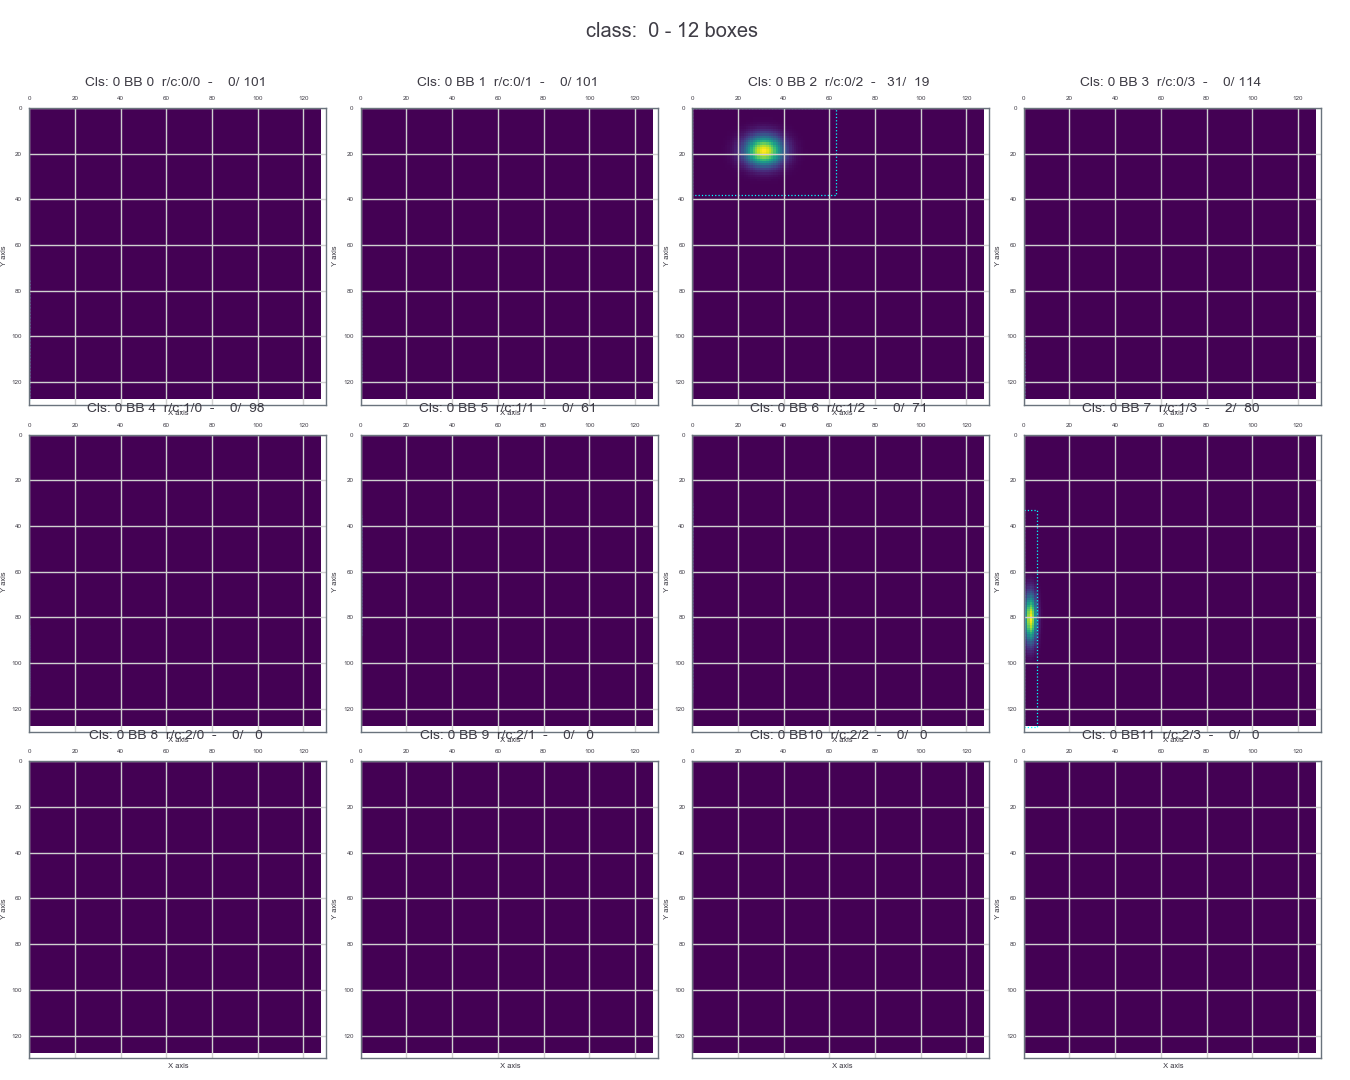

<IPython.core.display.Javascript object>


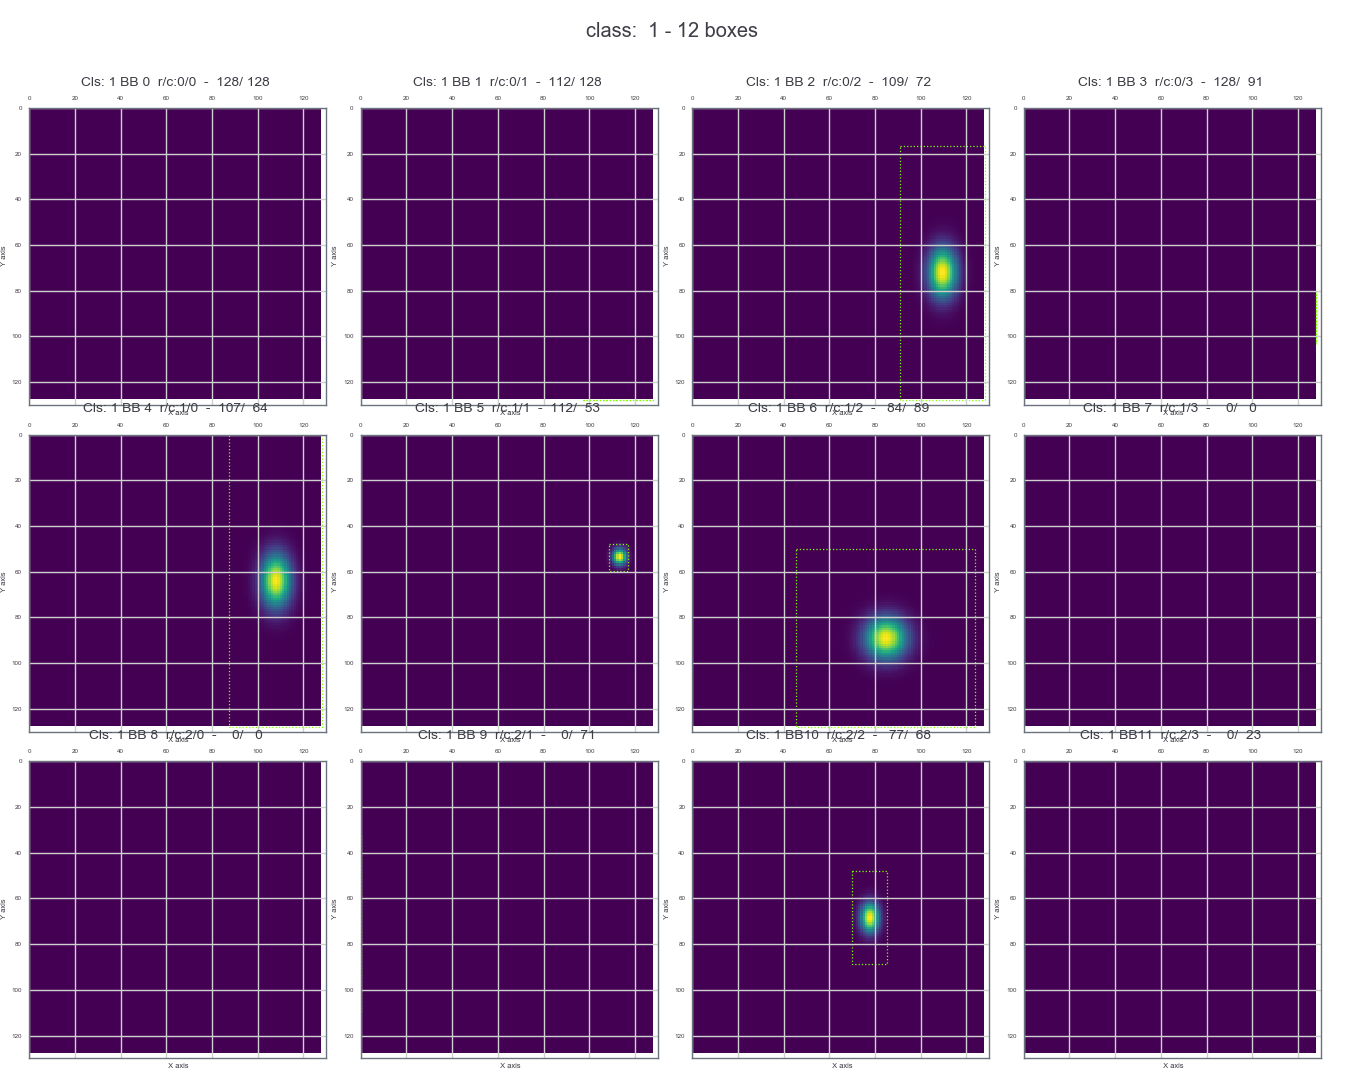

<IPython.core.display.Javascript object>


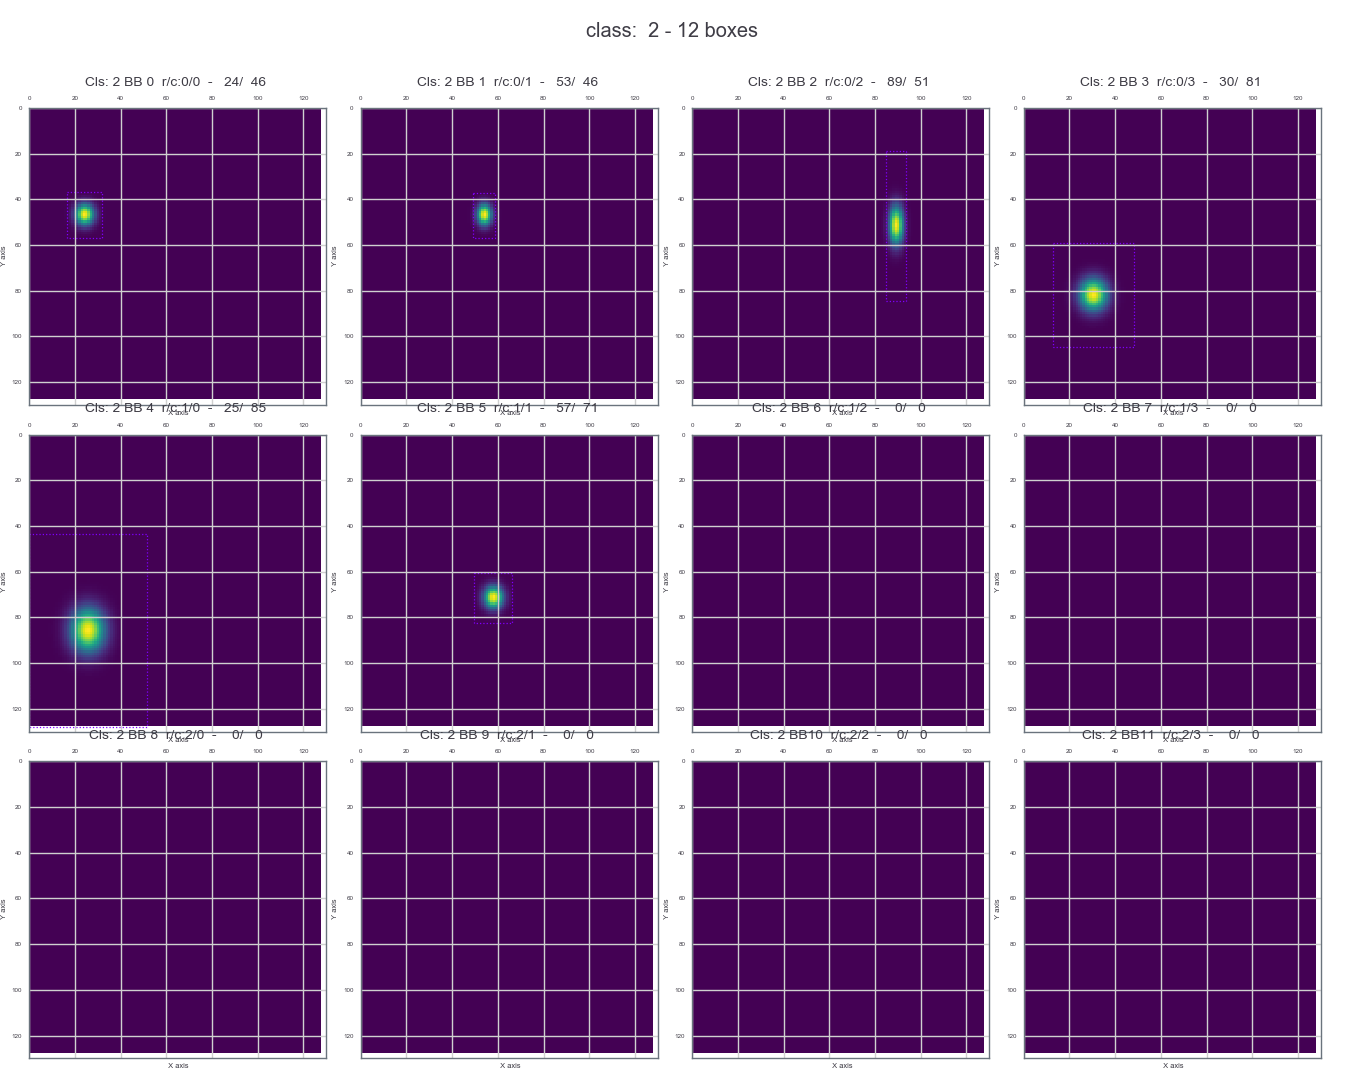

<IPython.core.display.Javascript object>


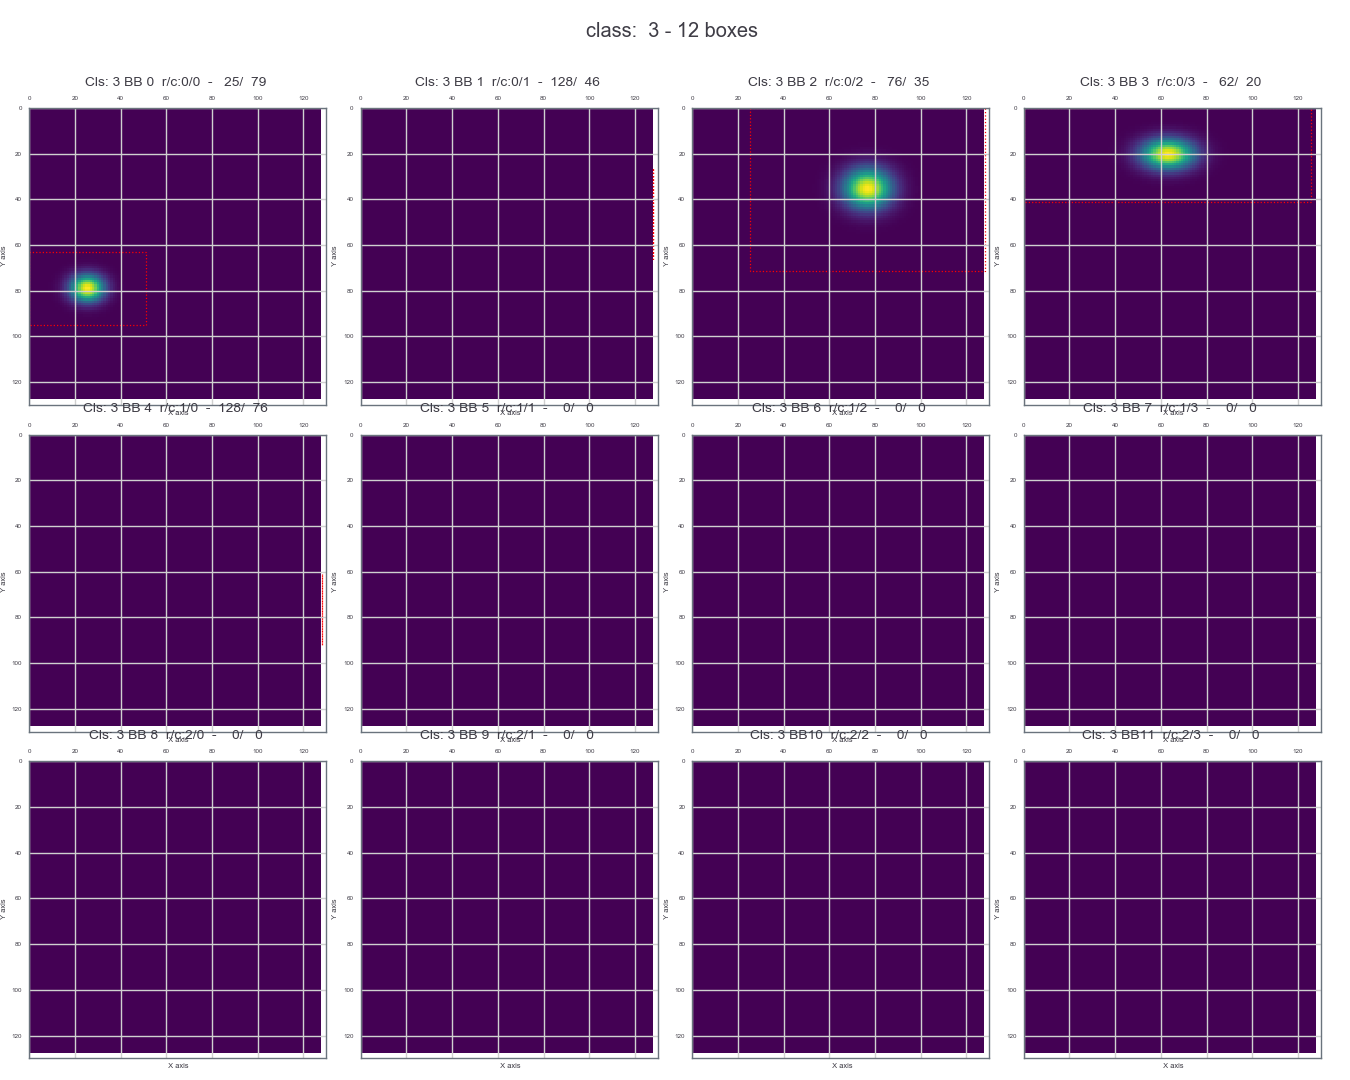

In [303]:
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,0,0])
plot_bbox_heatmaps(gauss_scatt[img], pred_tensor[img], width = 15, height=25, num_bboxes=12)

###  Display `gauss_heatmap` heatmap (not normalized, normlized, L2 normalized)

Image id:  87     Classes (1: circle, 2: square, 3: triangle ): 
[ 75.1388   0.     128.       0.       0.       0.5825   0.       0.       0.       0.       0.    ]


<IPython.core.display.Javascript object>


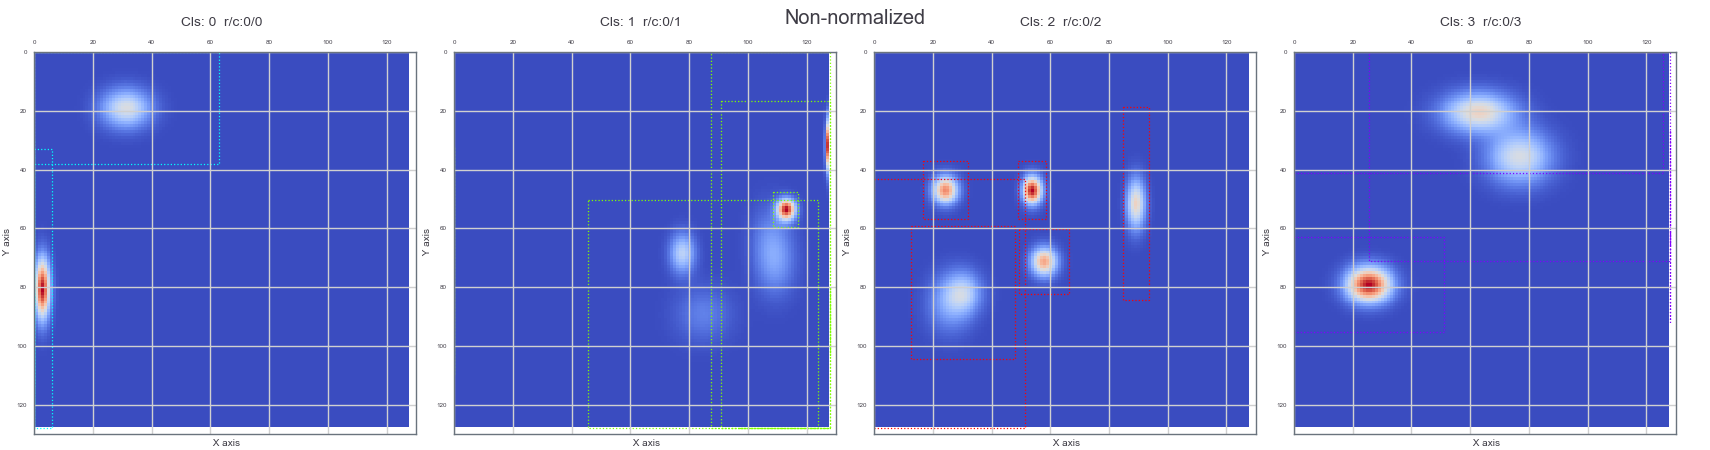

<IPython.core.display.Javascript object>


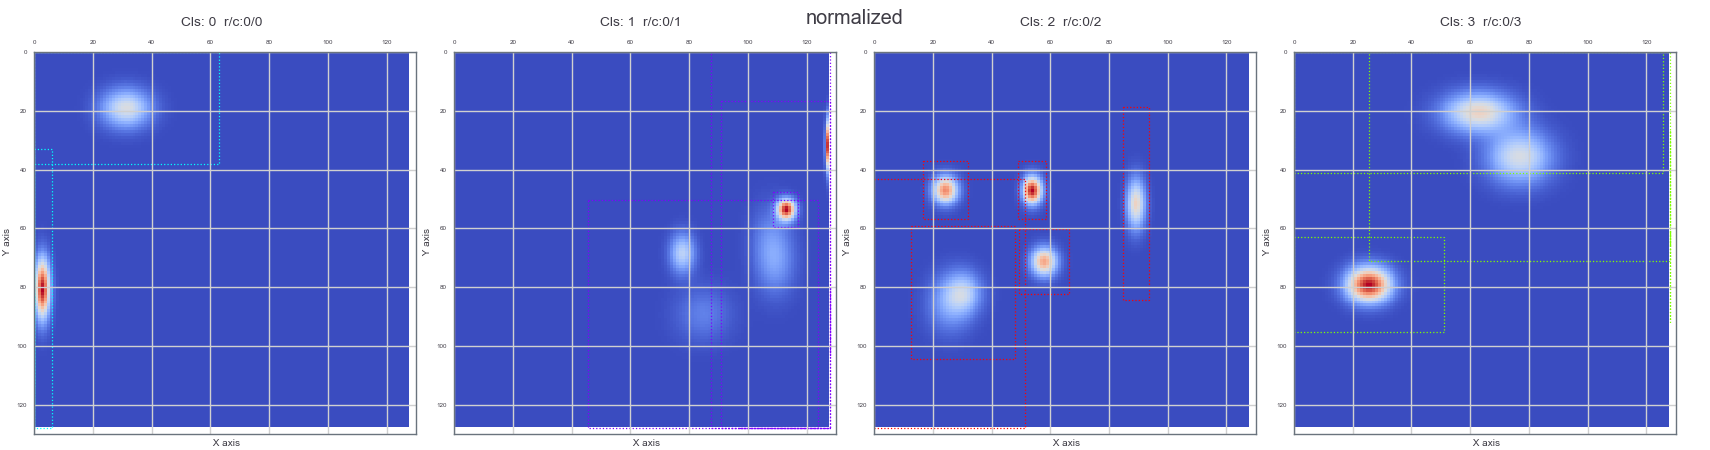

<IPython.core.display.Javascript object>


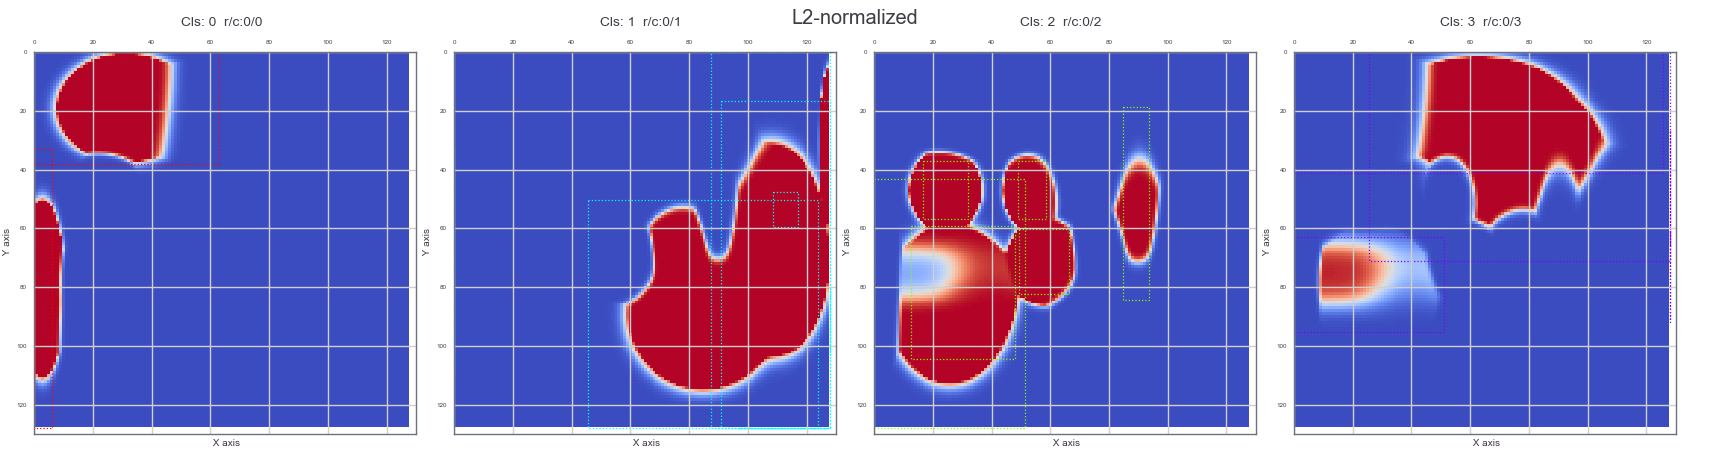

In [304]:

%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,0,0])
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='Non-normalized')
plot_one_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='normalized')
plot_one_heatmap(pred_heatmap_L2norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='L2-normalized')
# plot_heatmaps(pred_heatmap, pred_heatmap_scores, width = 15, num_bboxes=12)

###  Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

Image id:  87     Classes (1: circle, 2: square, 3: triangle ): 
[[ 128.      128.      128.      128.        1.        0.655     0.        0.        0.        0.        0.    ]
 [ 128.       97.4102  128.      128.        1.        0.5824    0.        0.        0.        0.        0.    ]
 [  16.5328   90.8564  128.      128.        1.        0.524   112.733  4107.        0.0274    0.0803    0.0671]
 [  80.247   128.      103.1459  128.        1.        0.5013    0.        0.        0.        0.        0.    ]
 [   0.       87.6242  128.      128.        1.        0.4965  117.4294 5120.        0.0229    0.0671    0.0561]
 [  47.6457  108.7067   59.5362  117.1743    1.        0.4421   32.8127   96.        0.3418    1.        0.8353]
 [  50.2464   45.5966  128.      123.8265    1.        0.4038  151.3924 6084.        0.0249    0.0728    0.0608]
 [   0.        0.        0.        0.        1.        0.3991    0.        0.        0.        0.        0.    ]
 [   0.        0.        0.    

<IPython.core.display.Javascript object>


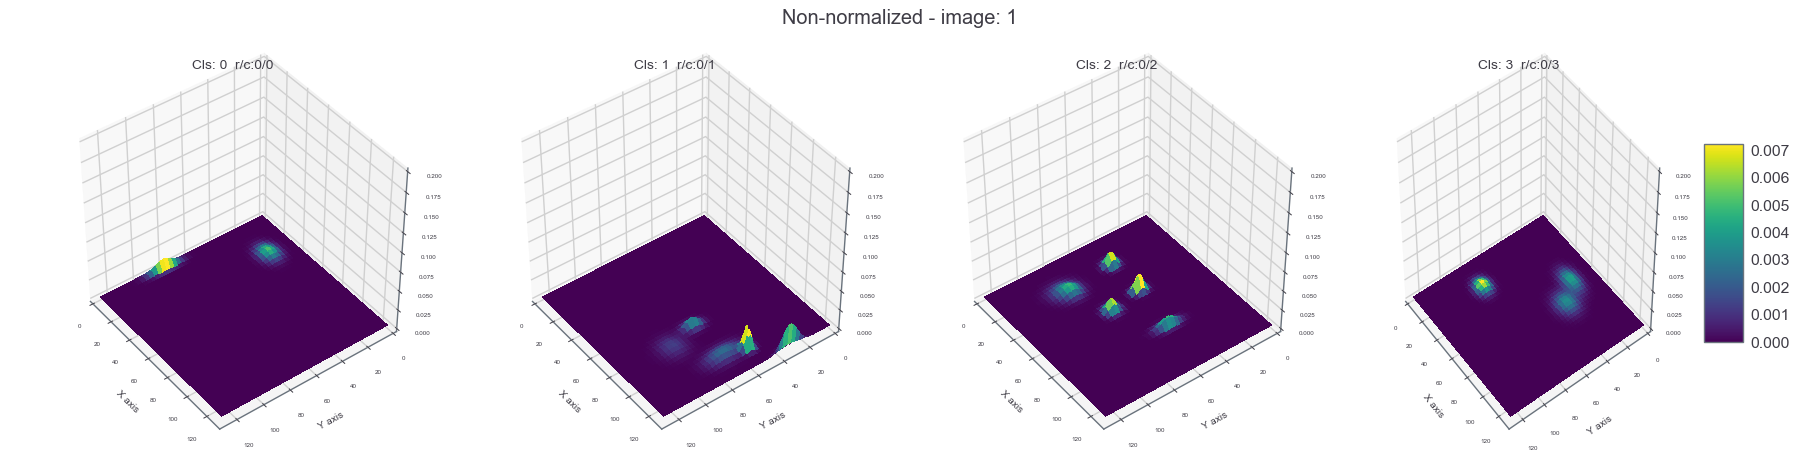

class: 0 row: 0 col: 0
class: 1 row: 0 col: 1
class: 2 row: 0 col: 2
class: 3 row: 0 col: 3


<IPython.core.display.Javascript object>


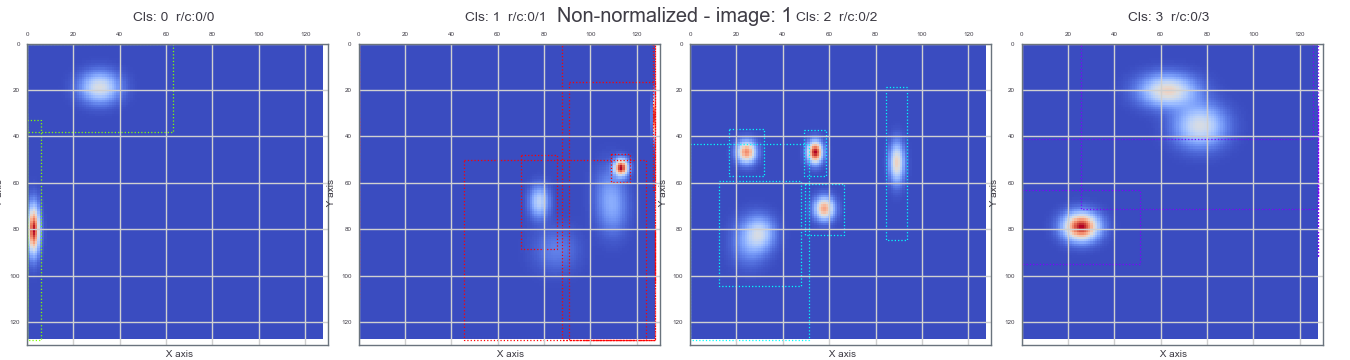

shape of z (4, 128, 128)
(128, 128) (128, 128)


<IPython.core.display.Javascript object>


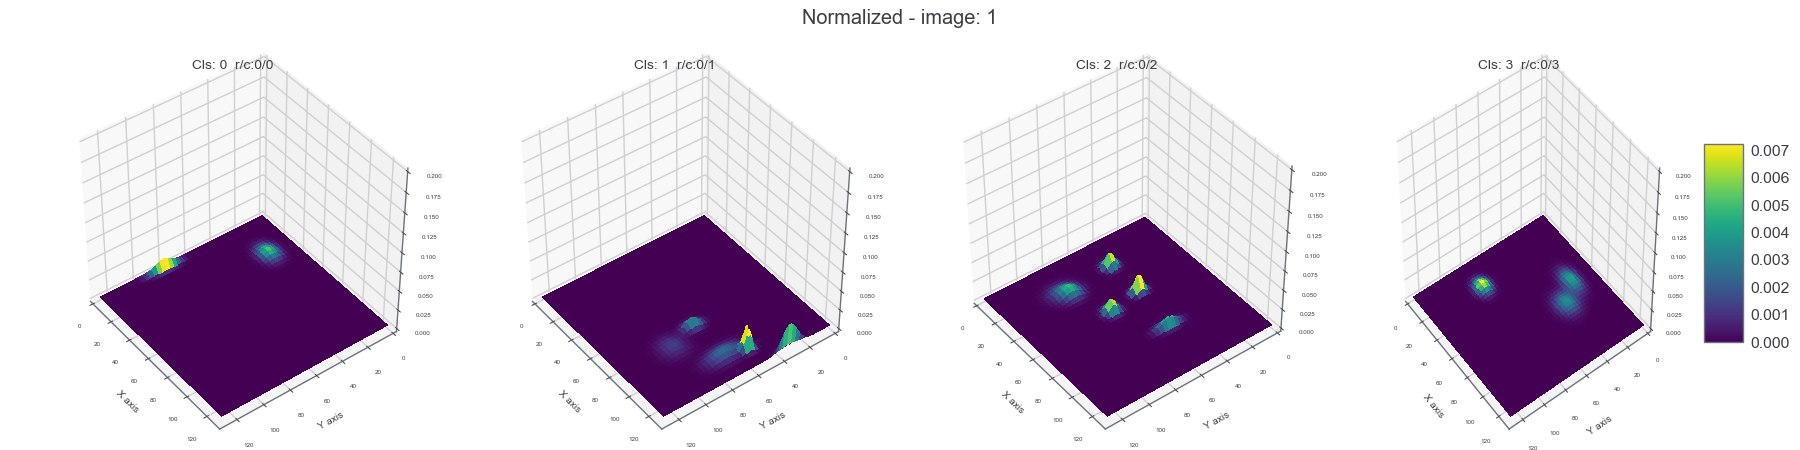

class: 0 row: 0 col: 0
class: 1 row: 0 col: 1
class: 2 row: 0 col: 2
class: 3 row: 0 col: 3


<IPython.core.display.Javascript object>


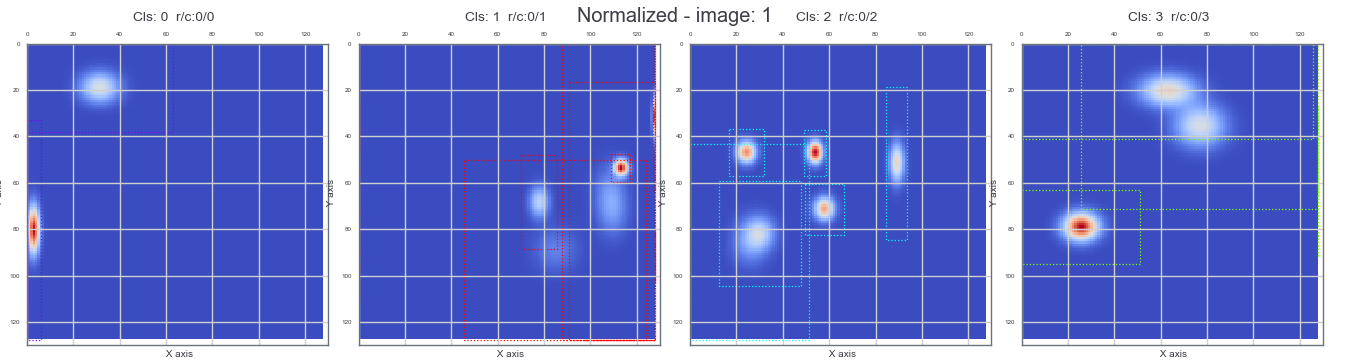

In [326]:
from mrcnn.visualize import plot_3d_heatmap
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)

ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)



####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])


####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_gaussian_tf()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
            print('img ',i,' class ', j, ' sum:',temp_sum[i,j])

###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

##  `development build_heatmap_tf ()` 

### Generate Multivariate Normal Distribution from Pred_Tensor

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`


Detections returned by `detect()` routine:

`[[ 25.          18.          80.          72.           2.           0.99936014]
  [ 51.           3.         106.          71.           3.           0.99924326]`

### Prepare values to pass to build_gaussian_tf

In [ ]:
img = 1
max_score = np.max(mrcnn_class, axis = -1)
max_class = np.argmax(mrcnn_class, axis = -1)
print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
print('max class[',img,']\n',max_class[img])
print('max score[',img,']\n',max_score[img])
print(' mrcnn class.shape ',mrcnn_class.shape)
print('marcnn_classe[',img,',:]\n',mrcnn_class[1,:])
# print(output_rois[1])
 


####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', gt_tensor.shape)
img = 1
print('Image ', img , '/ Class 0 ------------')
print(gt_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(gt_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(gt_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(gt_tensor[img,3])




### Plot heatmap produced by network `fcn_bilinear` and compare with `pred_gaussian`

<IPython.core.display.Javascript object>


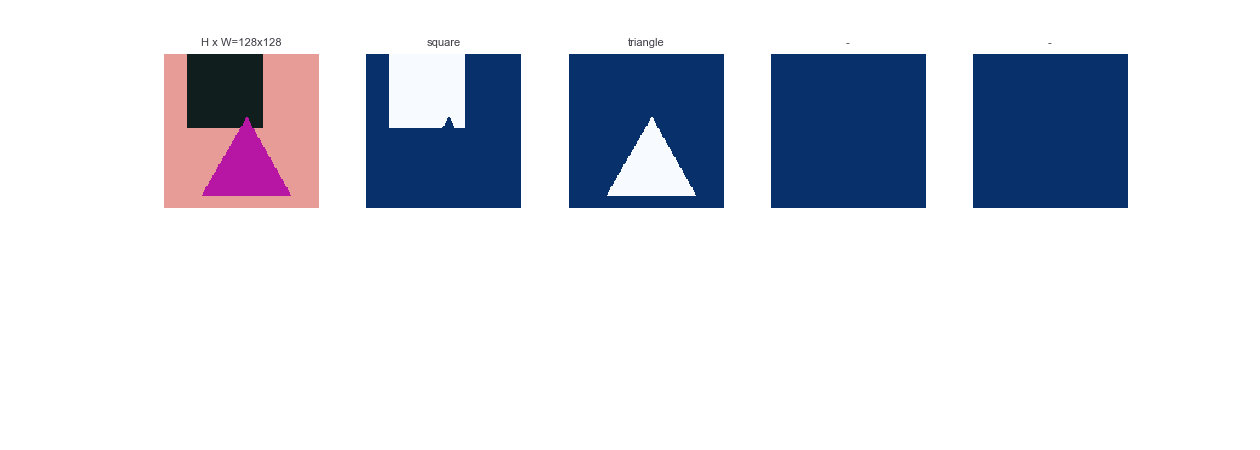

(5, 128, 128, 4) (5, 128, 128, 4)
[[ 46.4459  43.2326 128.     128.       2.       0.6289]
 [109.4121  52.4851 128.     105.0394   2.       0.5463]
 [ 69.6577  72.349   78.29    99.4742   2.       0.4957]
 [  0.       0.      74.7658   0.       2.       0.4862]
 [  0.      35.337  109.2249 108.471    2.       0.4816]
 [  0.       0.      24.8144  93.6202   2.       0.4306]
 [ 33.6141  58.0146 128.     113.95     2.       0.4139]
 [128.       0.     128.      26.6658   2.       0.4127]
 [ 33.8451  54.5086  75.7902 109.6297   2.       0.3883]
 [  5.3866   5.8942 112.2907  49.654    2.       0.36  ]]
(5, 4, 32, 6)
Image id:  0
Classes (1: circle, 2: square, 3: triangle ): 
[[  46.4459   43.2326  128.      128.        2.        0.6289  286.2646 6970.        0.0411    0.1437    0.1587]
 [ 109.4121   52.4851  128.      105.0394    2.        0.5463   41.6586 1007.        0.0414    0.1448    0.1598]
 [  69.6577   72.349    78.29     99.4742    2.        0.4957   55.9097  216.        0.2588    

<IPython.core.display.Javascript object>


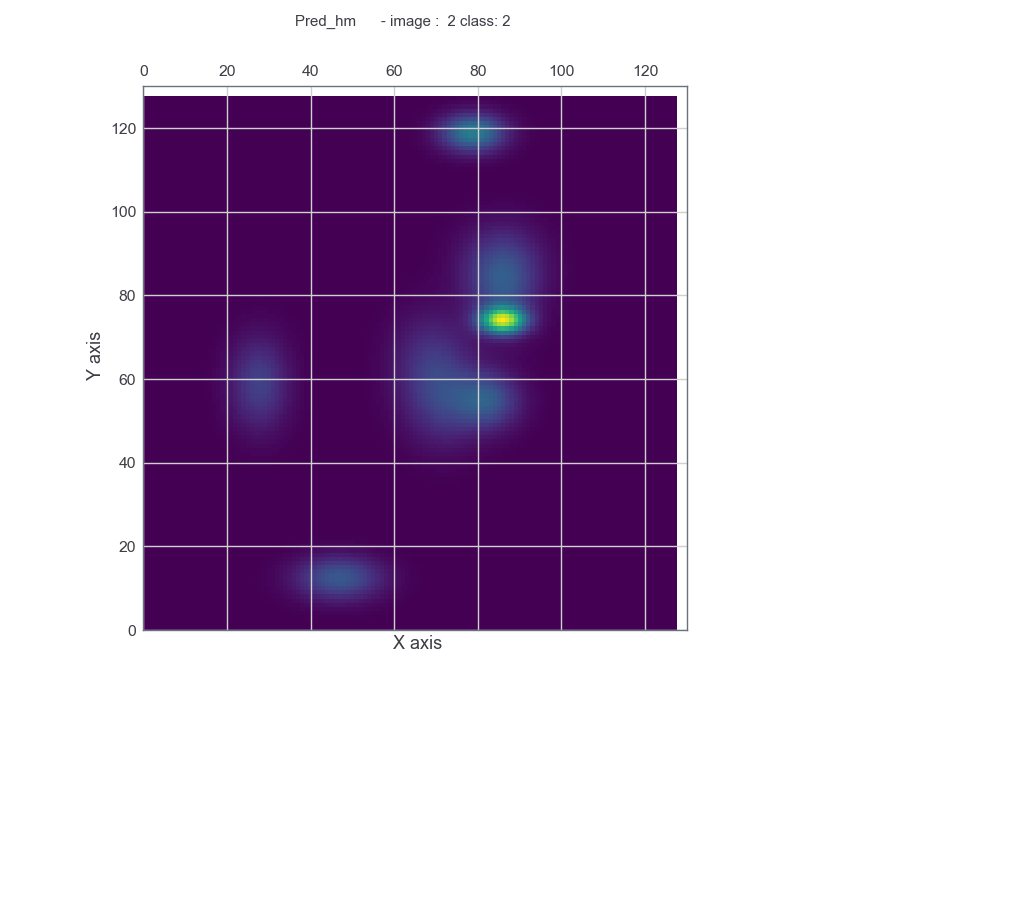

(128, 128) (128, 128)


<IPython.core.display.Javascript object>


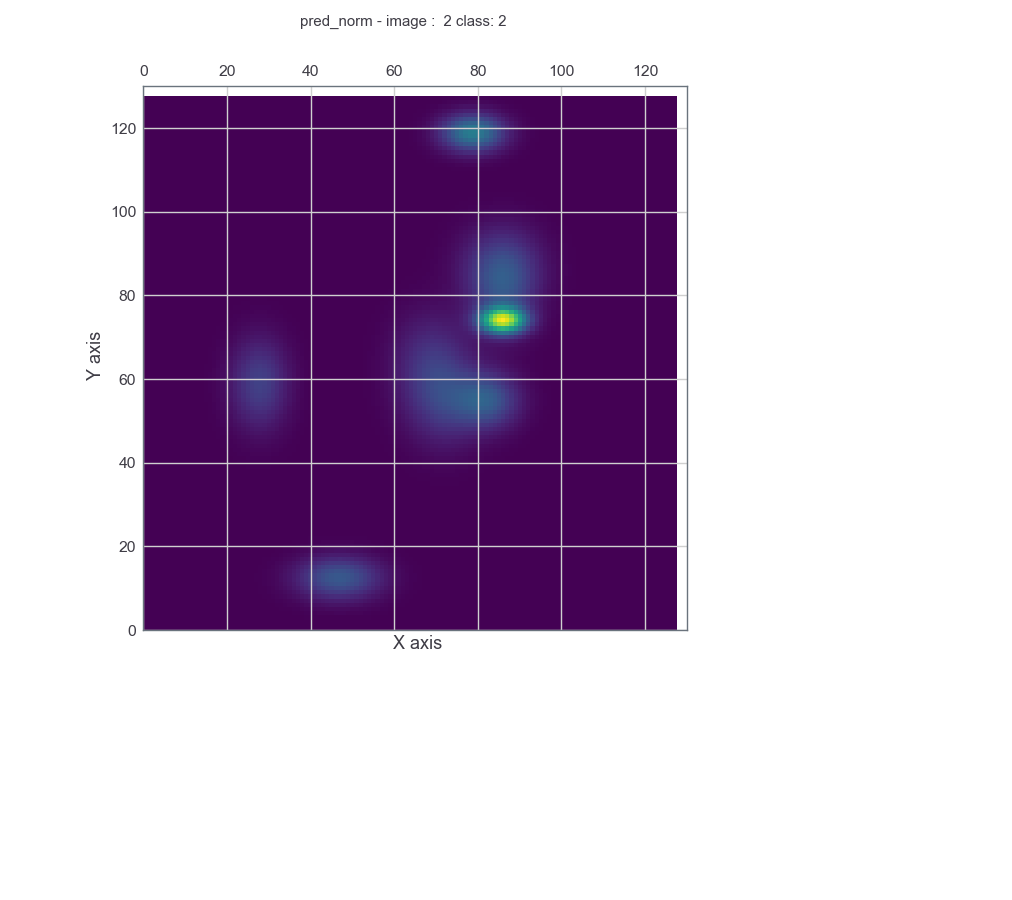

(128, 128) (128, 128)


<IPython.core.display.Javascript object>


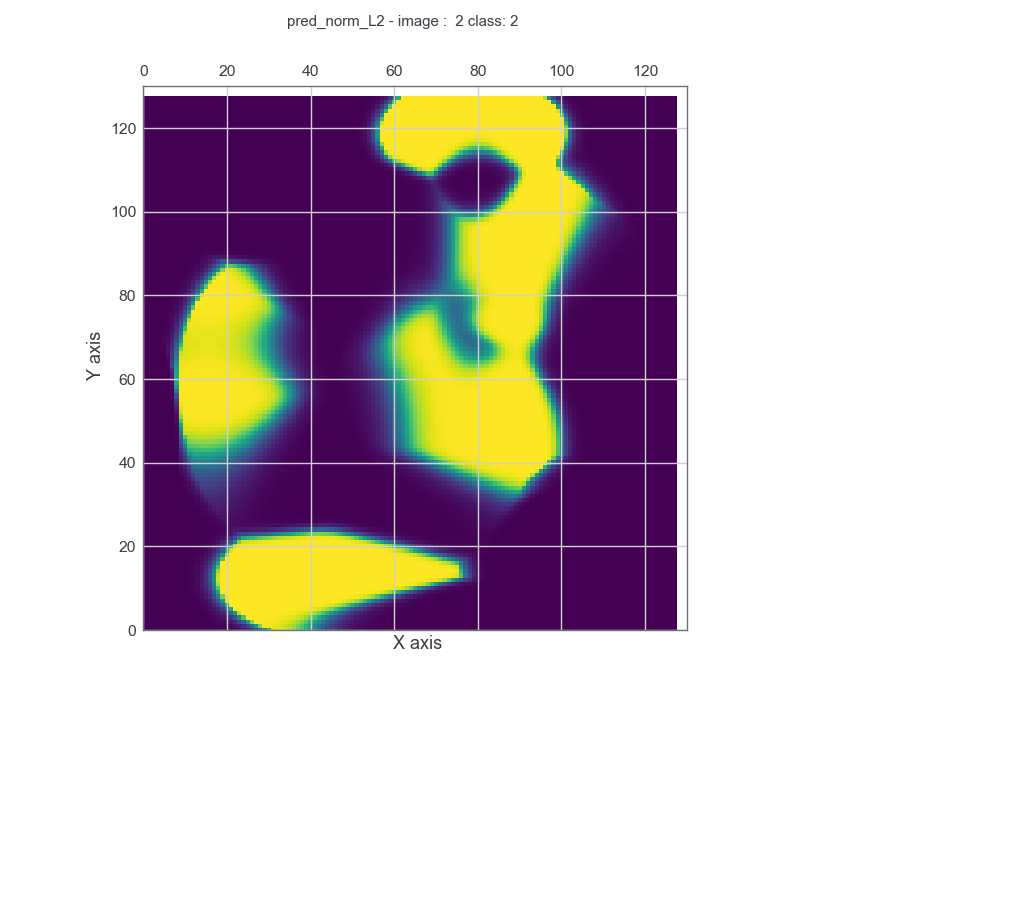

(128, 128) (128, 128)
Image id      :  1
Image metadata:  [  1 128 128   3   0   0 128 128   1   1   1   1]


<IPython.core.display.Javascript object>


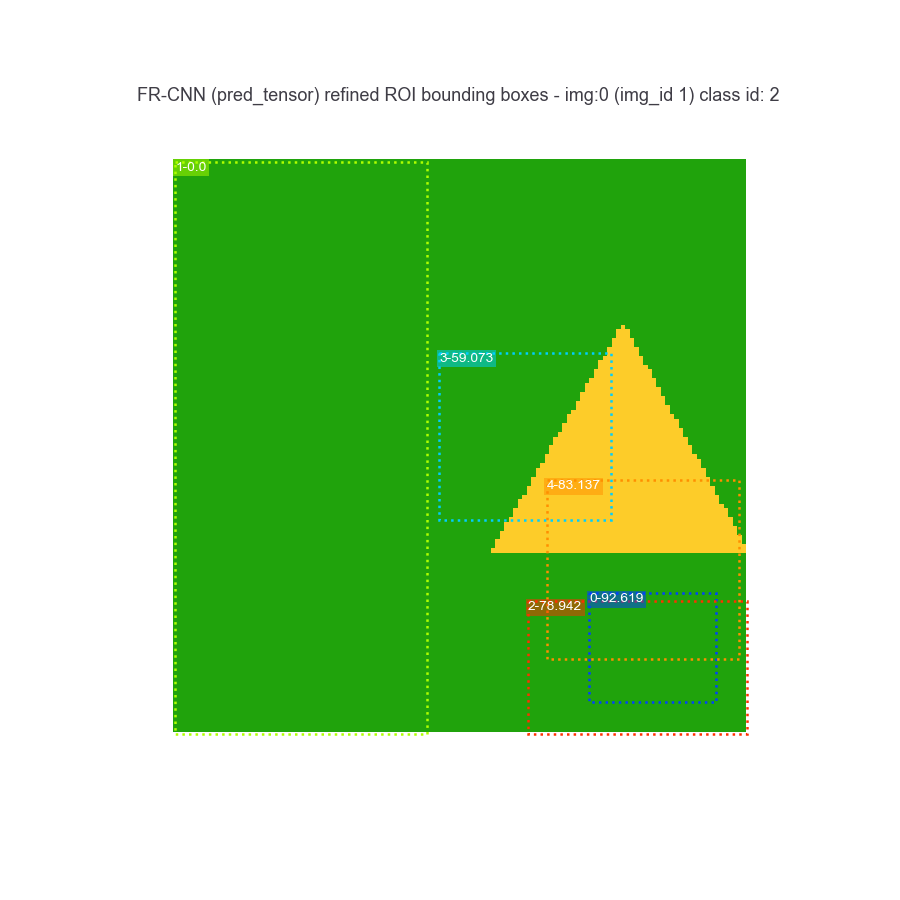

In [71]:
from mrcnn.visualize import plot_gaussian, plot_gaussian_2d
import matplotlib as plt

%matplotlib notebook
img = 2
cls = 2
image_id = input_image_meta[img,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
Zout1 = pred_heatmap     # gt_gaussiam 
Zout2 = pred_heatmap_norm  # fcn_bilinear
Zout3 = pred_heatmap_L2norm  # fcn_bilinear

print(Zout1.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
print(pred_tensor[img,cls,:10])
print(pred_tensor.shape)
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')

width = 9
# for j in [cls] : #range(num_classes):
print(pred_heatmap_scores[img,cls,:10])
ttl = 'Pred_hm      - image :  {} class: {} '.format(img,j)
plot_gaussian_2d(Zout1[img,:,:,j], title = ttl, width = width)

ttl = 'pred_norm - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout2[img,:,:,j], title = ttl, width = width)  

ttl = 'pred_norm_L2 - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout3[img,:,:,j], title = ttl, width = width)  


from mrcnn.visualize import display_gt_bboxes, display_roi_proposals
model_info = [model, config, dataset_train, train_generator]
display_roi_proposals(model_info, input_image_meta, pred_tensor, [cls], 0)

In [ ]:
%matplotlib notebook
width = 12
plot_gaussian2([pred_heatmap_norm, fcn_heatmap_norm], image_idx = 0, title = ttl, width = width)  


###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [23]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
print('XX shape', XX.shape)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
print('XX')
print(XX)
print('YY')
print(YY)
print(pos[0,:,:])
print(pos[0])
print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
mean = np.array([1,2])
covar = np.array([[1,0],[0,1]])
print(' mean  ', mean)
print(' covar ', covar)
mvna   = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

# mvnb = multivariate_normal(mean, covar_sqrd)
# prob_b = mvnb.pdf(pos)

# print(prob_a[35:50, 45:54])
# max_a = np.max(prob_a)
# print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

# print()

# print(' covar ', covar_sqrd)
# print(prob_b[35:50, 45:54])
# max_b = np.max(prob_b)
# print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

# print('max a , max_b ', max_a, max_b, max_a/max_b)

XX shape (128, 128)
XX
[[  0   1   2 ... 125 126 127]
 [  0   1   2 ... 125 126 127]
 [  0   1   2 ... 125 126 127]
 ...
 [  0   1   2 ... 125 126 127]
 [  0   1   2 ... 125 126 127]
 [  0   1   2 ... 125 126 127]]
YY
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [125 125 125 ... 125 125 125]
 [126 126 126 ... 126 126 126]
 [127 127 127 ... 127 127 127]]
[[  0.   0.]
 [  1.   0.]
 [  2.   0.]
 [  3.   0.]
 [  4.   0.]
 [  5.   0.]
 [  6.   0.]
 [  7.   0.]
 [  8.   0.]
 [  9.   0.]
 [ 10.   0.]
 [ 11.   0.]
 [ 12.   0.]
 [ 13.   0.]
 [ 14.   0.]
 [ 15.   0.]
 [ 16.   0.]
 [ 17.   0.]
 [ 18.   0.]
 [ 19.   0.]
 [ 20.   0.]
 [ 21.   0.]
 [ 22.   0.]
 [ 23.   0.]
 [ 24.   0.]
 [ 25.   0.]
 [ 26.   0.]
 [ 27.   0.]
 [ 28.   0.]
 [ 29.   0.]
 [ 30.   0.]
 [ 31.   0.]
 [ 32.   0.]
 [ 33.   0.]
 [ 34.   0.]
 [ 35.   0.]
 [ 36.   0.]
 [ 37.   0.]
 [ 38.   0.]
 [ 39.   0.]
 [ 40.   0.]
 [ 41.   0.]
 [ 42.   0.]
 [ 43.   0.]
 [ 44.   0.]
 [ 45

NameError: name 'grid' is not defined

In [33]:
with sess.as_default():
    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(80, dtype=tf.int32)
    Y = tf.range(80, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([1, 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', tf.shape(bef_pos).eval())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', tf.shape(pos_grid).eval())    
    pt2_den = tf.constant([[10,10,30,70]], dtype = tf.float32)
    print(type(pt2_den))
    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_den[:,3] - pt2_den[:,1]      # x2 - x1
    height = pt2_den[:,2] - pt2_den[:,0]
    print(width.eval(), type(width))
    print(height.eval(), type(height))
    cx     = pt2_den[:,1] + tf.div( width  , 2.0)
    cy     = pt2_den[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)
    print(means.eval())
    print(covar.eval())

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())


    X/Y shapes : (80, 80) (80, 80)
    Ones:     (1, 1, 1)
    ones_exp * X (1, 1, 1) * (80, 80) =  (1, 80, 80)
    ones_exp * Y (1, 1, 1) * (80, 80) =  (1, 80, 80)
    before transpse  [ 1 80 80  2]
    after transpose  [80 80  1  2]
<class 'tensorflow.python.framework.ops.Tensor'>
[60.] <class 'tensorflow.python.framework.ops.Tensor'>
[20.] <class 'tensorflow.python.framework.ops.Tensor'>
[[40. 20.]]
[[5.4772 3.1623]]
     Prob_grid shape before tanspose:  (80, 80, 1)
     Prob_grid shape after tanspose:  (1, 80, 80)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (80, 80, 1, 2)
    << output probabilities shape: (1, 80, 80)
